In [1]:
import sys

import pandas as pd
import numpy as np
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from tensorflow import keras

sys.path.append('../src')
import columnar as col

%load_ext autoreload
%autoreload 2



## load dataset and split for cross validation

In [219]:
TASK = 'petfinder'

In [220]:
# loadd data
loader = col.DataLoader(TASK, root='../')
df = loader.load_data()
feature_selection = col.FeatureSelection(**loader.get_selected_features(df))

# split data
df_train, df_test = train_test_split(df, test_size=.2, random_state=123)

X_train, y_train = feature_selection.select_features(df_train)
ds_train = col.embeddings.data.df_to_dataset(X_train, y_train, batch_size=32)

X_test, y_test = feature_selection.select_features(df_test)
ds_test = col.embeddings.data.df_to_dataset(X_test, y_test, batch_size=32, shuffle=False)

# setup scorer
scorer = col.Scorer(
    acc=lambda ytrue, ypreds: metrics.accuracy_score(ytrue, ypreds > .5),
    f1=lambda ytrue, ypreds: metrics.f1_score(ytrue, ypreds > .5),
    auc=metrics.roc_auc_score,
)


In [221]:
petfinder

NameError: name 'petfinder' is not defined

## Utility Function

In [222]:
def get_embedding_values(encoder: col.embeddings.models.TFCatEmbsEncoder, 
                         column: col.feature_selection.DatasetColumn) -> pd.Series:
    """returns a Series with the unique categorical values as index and embedding weights
    as values. Note: encoder needs to be trained."""
    layer = encoder.encoding_layers.get(column)
    
    # map embedding values to index values
    embedding_values = pd.Series(index=layer.index.get_vocabulary(), 
                                 data=layer.embedding.get_weights()[0].reshape(-1,))
    
    return embedding_values

## Generating 1-dim Embeddings

In [223]:
embedding_based_model = col.embeddings.wrapper.MonoEmbeddings('single')
X_train_transformed = embedding_based_model.fit_transform(X_train, y_train, feature_selection.categoricals, epochs=3)

2022-02-26 22:48:46.311834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 22:48:46.748055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 22:48:47.139845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 22:48:47.537883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 22:48:47.922627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 22:48:48.308029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 22:48:48.694071: I tensorflow/core/grappler/optimizers/cust

Epoch 1/3


2022-02-26 22:48:57.462717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 28s 69ms/step - loss: 0.6085 - accuracy: 0.6152
Epoch 2/3
375/375 [==============================] - 26s 70ms/step - loss: 0.5327 - accuracy: 0.7257
Epoch 3/3
375/375 [==============================] - 26s 69ms/step - loss: 0.4485 - accuracy: 0.7845


2022-02-26 22:50:16.410150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## Compare MeanTargetEncoder mapping with single embeddings

In [224]:
min_cardinality = 12
cats_uniques = X_train[feature_selection.categoricals].nunique() 
columns_with_high_cardinality = cats_uniques[cats_uniques > min_cardinality]

print(columns_with_high_cardinality)

breed1        168
breed2        128
quantity       17
state          14
rescuerid    4821
dtype: int64


In [229]:
columns_with_high_cardinality.drop('quantity', inplace=True)

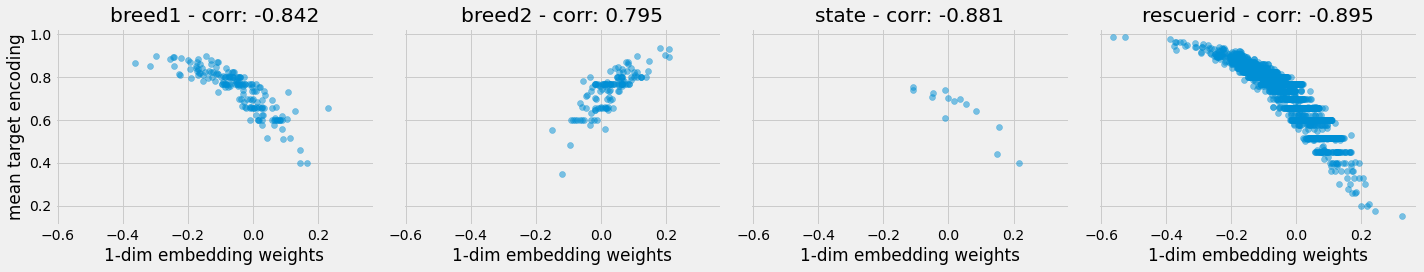

In [230]:
# categorical columns with 
ncols = len(columns_with_high_cardinality)

mte = col.transform.mono.MeanTargetEncoder()
mte.fit_transform(X_train, y_train, 
                  columns=columns_with_high_cardinality.index)
    
fig, ax = plt.subplots(1, ncols, figsize=(5*ncols,4), sharey=True, sharex=True)
for i, column in enumerate(columns_with_high_cardinality.index):

    # map embedding values to index values
    embedding_values = get_embedding_values(encoder=embedding_based_model.model.encoder, 
                                            column=column)

    # get mapper for column of interest ) (dict)
    mte_values: dict = getattr(mte.mapper, column)
    
    # get support size for each category
    category_size = X_train[column].value_counts()
    
    # resize to get values between 0 and 1
    n = 20
    alpha = category_size.clip(1, 2 * n) / (2 * n)
    

    df = pd.DataFrame({'embedding': embedding_values, 
                       'mte': mte_values})
    
    # df = df.drop(['[UNK]'])
    
    # plot results
    ax[i].scatter(df.embedding, df.mte, alpha=.5)
    ax[i].set_title(column + f' - corr: {df.corr().iloc[1,0]:.3f}')
    ax[i].set_xlabel('1-dim embedding weights')
    if i == 0:
        ax[i].set_ylabel('mean target encoding');
    plt.tight_layout()
    
plt.savefig(f'../figures/mte_embs_correlation_{TASK}.png')